# MNIST Digit Addition Problem

This is an adaptation of the experiment on Single Digit Addition, on a more complicated setup with multiple digits.

Consider the classifier $\mathtt{addition([X_1,X_2],[Y_1,Y_2],N)}$. $\mathtt{[X_1,X_2]}$ and $\mathtt{[Y_1,Y_2]}$ are lists of images of digits, representing two multi-digit numbers; $\mathtt{N}$ is a natural number corresponding to the sum of the two multi-digit numbers. The classifier must return a confidence in the validity of the addition.

The steps are similar to that of the Single Digit Addition example (read the first notebook for more details).

In [1]:
import tensorflow as tf
import ltn
import baselines, data, commons
import matplotlib.pyplot as plt

Dataset of images for the digits X1, X2, Y1 and Y2, and their label Z s.t. 10\*X1+X2+10\*X2+Y2=Z.

2021-08-31 05:48:57.319207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 05:48:57.326318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 05:48:57.326934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 05:48:57.327946: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Result label is 102


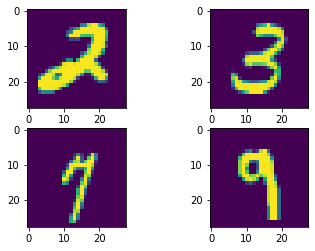

In [2]:
ds_train, ds_test = data.get_mnist_op_dataset(
        count_train=3000,
        count_test=1000,
        buffer_size=3000,
        batch_size=16,
        n_operands=4,
        op=lambda args: 10*args[0]+args[1]+10*args[2]+args[3])

# Visualize one example
x1, x2, y1, y2, z = next(ds_train.as_numpy_iterator())
plt.subplot(221)
plt.imshow(x1[0][:,:,0])
plt.subplot(222)
plt.imshow(x2[0][:,:,0])
plt.subplot(223)
plt.imshow(y1[0][:,:,0])
plt.subplot(224)
plt.imshow(y2[0][:,:,0])
print("Result label is %i" % z[0])

LTN Model and Loss

In [3]:
### Predicates
logits_model = baselines.SingleDigit(inputs_as_a_list=True)
Digit = ltn.Predicate.FromLogits(logits_model, activation_function="softmax")
### Variables
d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))
d3 = ltn.Variable("digits3", range(10))
d4 = ltn.Variable("digits4", range(10))
### Operators
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

In [4]:
# mask
add = ltn.Function.Lambda(lambda inputs: inputs[0]+inputs[1])
times = ltn.Function.Lambda(lambda inputs: inputs[0]*inputs[1])
ten = ltn.Constant(10, trainable=False)
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])
two_digit_number = lambda inputs : add([times([ten,inputs[0]]), inputs[1] ])

@tf.function
def axioms(images_x1,images_x2,images_y1,images_y2,labels_z,p_schedule):
    images_x1 = ltn.Variable("x1", images_x1)
    images_x2 = ltn.Variable("x2", images_x2)
    images_y1 = ltn.Variable("y1", images_y1)
    images_y2 = ltn.Variable("y2", images_y2)
    labels_z = ltn.Variable("z", labels_z)
    axiom = Forall(
            ltn.diag(images_x1,images_x2,images_y1,images_y2,labels_z),
            Exists(
                (d1,d2,d3,d4),
                And(
                    And(Digit([images_x1,d1]),Digit([images_x2,d2])),
                    And(Digit([images_y1,d3]),Digit([images_y2,d4]))
                ),
                mask=equals([labels_z, add([ two_digit_number([d1,d2]), two_digit_number([d3,d4]) ]) ]),
                p=p_schedule
            ),
            p=2
        )
    sat = axiom.tensor
    return sat

x1, x2, y1, y2, z = next(ds_train.as_numpy_iterator())
axioms(x1, x2, y1, y2, z, tf.constant(2.))

2021-08-31 05:49:02.985619: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-31 05:49:03.906036: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202
2021-08-31 05:49:04.490647: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(), dtype=float32, numpy=0.00020378828>

Optimizer, training steps and metrics

In [5]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
}

@tf.function
def train_step(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x1 = tf.argmax(logits_model(images_x1),axis=-1, output_type=tf.int32)
    predictions_x2 = tf.argmax(logits_model(images_x2),axis=-1, output_type=tf.int32)
    predictions_y1 = tf.argmax(logits_model(images_y1),axis=-1, output_type=tf.int32)
    predictions_y2 = tf.argmax(logits_model(images_y2),axis=-1, output_type=tf.int32)
    predictions_z = 10*predictions_x1+predictions_x2+10*predictions_y1+predictions_y2
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
@tf.function
def test_step(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs):
    # loss
    loss = 1.- axioms(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x1 = tf.argmax(logits_model(images_x1),axis=-1, output_type=tf.int32)
    predictions_x2 = tf.argmax(logits_model(images_x2),axis=-1, output_type=tf.int32)
    predictions_y1 = tf.argmax(logits_model(images_y1),axis=-1, output_type=tf.int32)
    predictions_y2 = tf.argmax(logits_model(images_y2),axis=-1, output_type=tf.int32)
    predictions_z = 10*predictions_x1+predictions_x2+10*predictions_y1+predictions_y2
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))

Training

In [6]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}


In [7]:
commons.train(
    20,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    scheduled_parameters=scheduled_parameters
)

Epoch 0, train_loss: 0.9951, train_accuracy: 0.2786, test_loss: 0.9886, test_accuracy: 0.5873
Epoch 1, train_loss: 0.9865, train_accuracy: 0.7207, test_loss: 0.9863, test_accuracy: 0.7044
Epoch 2, train_loss: 0.9845, train_accuracy: 0.8032, test_loss: 0.9861, test_accuracy: 0.7004
Epoch 3, train_loss: 0.9840, train_accuracy: 0.8248, test_loss: 0.9849, test_accuracy: 0.7500
Epoch 4, train_loss: 0.8967, train_accuracy: 0.8268, test_loss: 0.8972, test_accuracy: 0.7817
Epoch 5, train_loss: 0.8885, train_accuracy: 0.8733, test_loss: 0.8995, test_accuracy: 0.7718
Epoch 6, train_loss: 0.8857, train_accuracy: 0.8953, test_loss: 0.8927, test_accuracy: 0.8204
Epoch 7, train_loss: 0.8833, train_accuracy: 0.9049, test_loss: 0.8933, test_accuracy: 0.8145
Epoch 8, train_loss: 0.7024, train_accuracy: 0.8803, test_loss: 0.7283, test_accuracy: 0.7887
Epoch 9, train_loss: 0.6943, train_accuracy: 0.8906, test_loss: 0.7250, test_accuracy: 0.7996
Epoch 10, train_loss: 0.6826, train_accuracy: 0.9189, test_l